In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment2RRBSDataSource').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

# Download data files

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file

data_dir = 'data/assignment2'
meta_csv_filepath = os.path.join(data_dir, 'MetaPolished.csv')
features_csv_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv')
features_zip_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip')

# download meta file
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/MetaPolished.csv',
              out_filepath=meta_csv_filepath)

# download features file if does not exists
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip',
              out_filepath=features_csv_filepath, 
              intermediate_archive_filepath=features_zip_filepath,
              archive_format='zip')


DEBUG:download_file:file data/assignment2/MetaPolished.csv already exists; do not download again
DEBUG:download_file:file data/assignment2/FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv already exists; do not download again


CPU times: user 1.62 s, sys: 4.16 s, total: 5.78 s
Wall time: 1.01 s


In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment2RRBSDataSource

data_source = Assignment2RRBSDataSource(
    meta_csv_filepath=meta_csv_filepath,
    features_csv_filepath=features_csv_filepath,
    features_pickle_cache_filepath=os.path.join(data_dir, 'features_cache.pickle'))

X, y = data_source.load()

DEBUG:Assignment2RRBSDataSource:load
DEBUG:Assignment2RRBSDataSource:loading features from cache file "data/assignment2/features_cache.pickle"...
DEBUG:Assignment2RRBSDataSource:loaded; shape=(182, 5201794)
DEBUG:Assignment2RRBSDataSource:joining based on ID
DEBUG:Assignment2RRBSDataSource:joined; shape=(182, 5201797)
DEBUG:Assignment2RRBSDataSource:creating y
DEBUG:Assignment2RRBSDataSource:creating X
DEBUG:Assignment2RRBSDataSource:loaded


CPU times: user 2.65 s, sys: 1.89 s, total: 4.53 s
Wall time: 5.42 s


In [4]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=1,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test = clock_trainer.train_test_split(X, y, test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(X_train=X_train, y_train=y_train, alpha_count=10 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.1...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.2...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.30000000000000004...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.4...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.5...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.6000000000000001...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.7000000000000001...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.8...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.9...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


CPU times: user 16min 1s, sys: 4min 32s, total: 20min 33s
Wall time: 16min 46s


# Plot hyperparameter optimization result

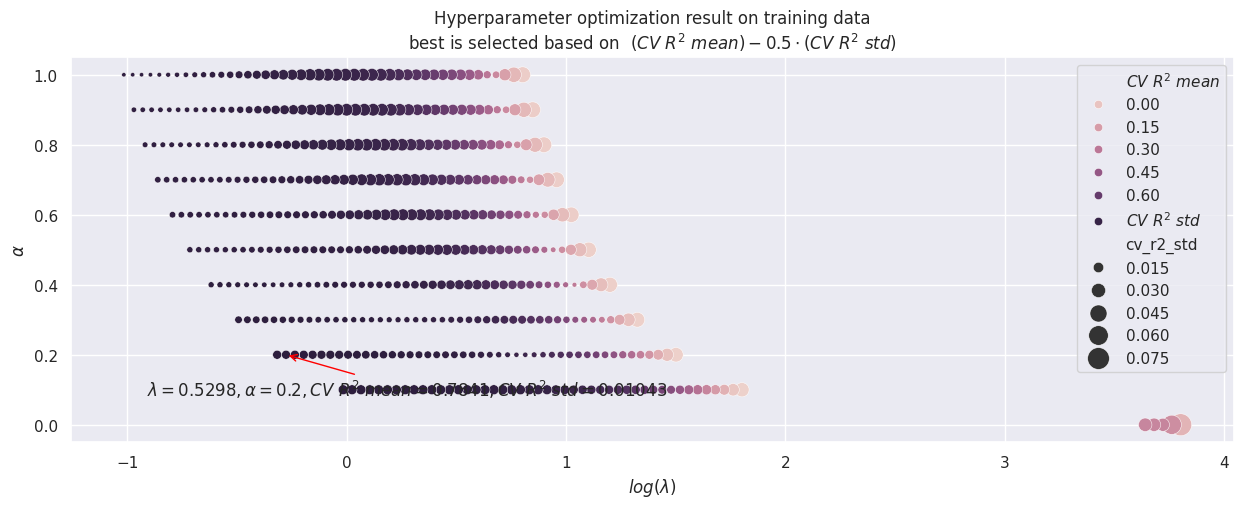

In [5]:
clock_trainer.plot_hyperparameter_optimization_result(
    hyperparameter_result=hyperparameter_result, 
    hyperparameter_stats=hyperparameter_stats)

# Predict on test data using the best model

In [6]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

print('best_lambda', best_lambda, best_model.lambda_max_, best_model.lambda_best_ , best_model.cut_point)

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_pred = best_model.predict(X = X_test, lamb=best_lambda)


best_lambda 0.5297837157690435 0.5297837157690435 [0.52978372] 0.5


# Plot linear regression result

In [ ]:
stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(y_true=y_test, y_pred=y_pred, stats=stats, alpha=best_alpha, lamb=best_lambda)
